# Time Series Project 2022/2023


### Michail Dadopoulos AEM:9989

### Importing necessary libraries

In [220]:
import mpld3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from nolitsa import dimension, delay

## Part A

### Reading data

In [93]:
d89 = pd.read_csv('./Downloads/EruptionData/eruption1989.dat',header=None)
d00 = pd.read_csv('./Downloads/EruptionData/eruption2000.dat',header=None)
d11 = pd.read_csv('./Downloads/EruptionData/eruption2011.dat',header=None)


### Choosing  data for analysis

In [94]:
#shape of eruption1989 data
n=d89.shape[0]
#setting random number generator
rng = np.random.default_rng(12345)
#finding 2 random number that will be the index in the data that we will choose n consecutive values from eruption2000 and  eruption2011
n1 = rng.integers(low=0, high=d00.shape[0]-n)
n2=rng.integers(low=0, high=d00.shape[0]-n)
print("Random numbers:",n1,n2)
#chosing in eruption2000 and  eruption201 only the data i will use
d00=d00.iloc[n1:n1+n]
d11=d00.iloc[n2:n2+n]

Random numbers: 308 100


### Function for plotting time-series

In [99]:
def plot_df(df, x, y, title="", xlabel='index', ylabel='Waiting time between eruptions ', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    



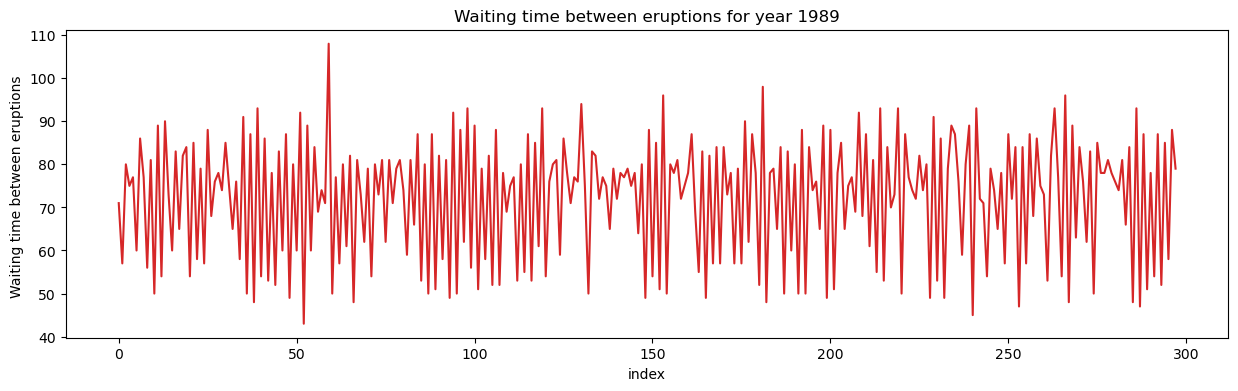

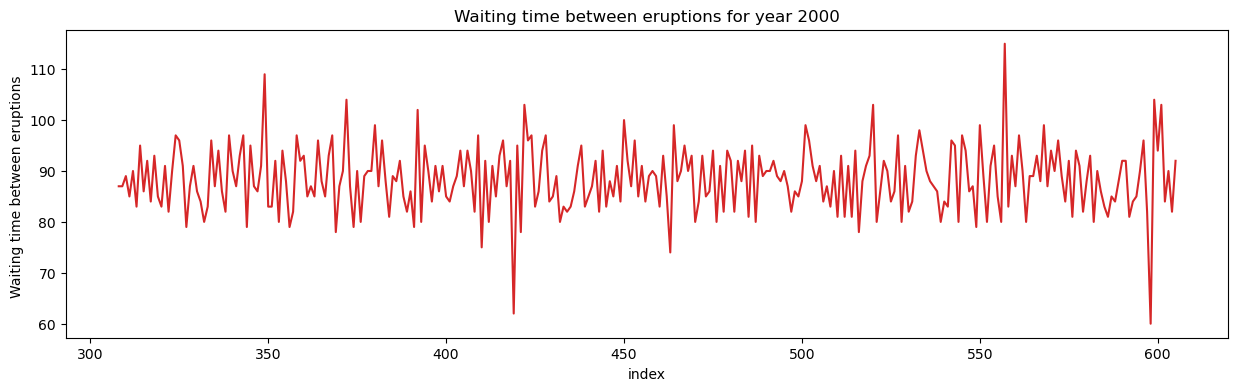

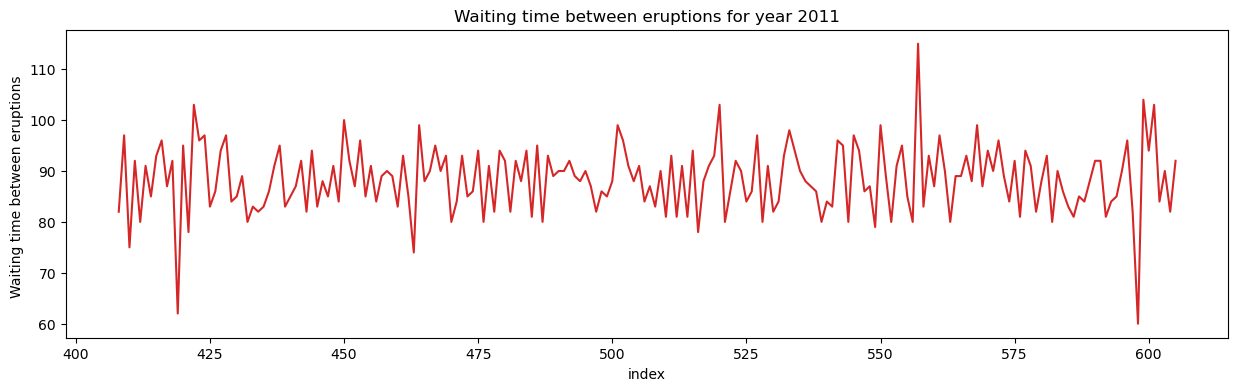

In [100]:
plot_df(d89, x=d89.index.values, y=d89.values, title='Waiting time between eruptions for year 1989')
plot_df(d00, x=d00.index.values, y=d00.values, title='Waiting time between eruptions for year 2000')
plot_df(d11, x=d11.index.values, y=d11.values, title='Waiting time between eruptions for year 2011')

### 1)Checking if time-series are white noise

Ljung-Box test for year 1989:  p = [3.39462078e-34 7.83714746e-53 7.89845152e-65 1.48074837e-73
 5.76452839e-78 6.70287948e-81 3.24247205e-84 2.33255925e-87
 4.62292485e-90 2.57462771e-91 5.25405865e-93 5.43218195e-95
 2.48198661e-96 5.24787048e-97 3.08437293e-97 4.21946268e-97
 2.22130152e-96 1.22984090e-95 6.61282077e-95 2.99144096e-94]
Ljung-Box test for year 2000:  p = [0.00013134 0.00058335 0.00020269 0.00059128 0.00132684 0.00244034
 0.00401058 0.00176024 0.00163873 0.00274288 0.00273156 0.00432072
 0.00700779 0.01092117 0.01427984 0.02008576 0.01374192 0.02007951
 0.02741215 0.03083822]
Ljung-Box test for year 2011: p = [0.00103455 0.00239093 0.0006977  0.00154768 0.00240459 0.00462936
 0.00716671 0.00721138 0.00776406 0.00565692 0.00109722 0.00109247
 0.0017182  0.00283386 0.00441134 0.00654432 0.00380854 0.00576329
 0.00796426 0.00998202]


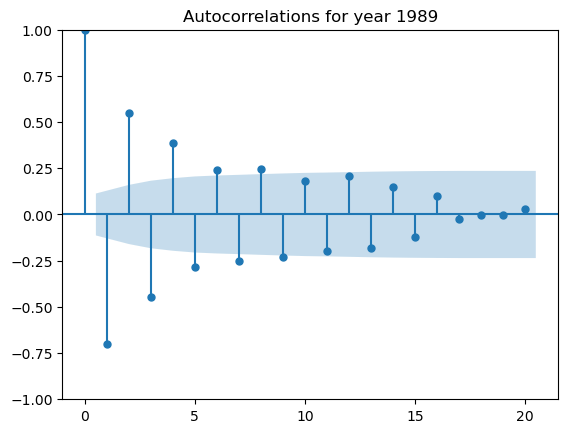

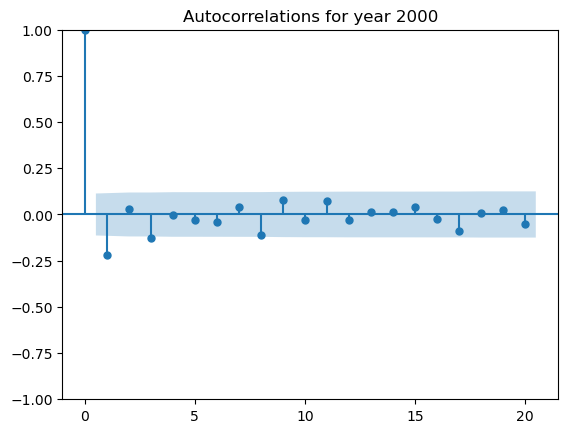

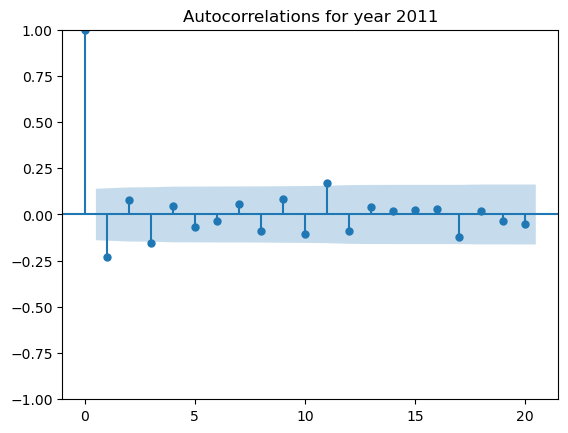

In [146]:

# Calculate the autocorrelations of the time series 20 lags for every year
lags = 20
acf_vals89 = acf(d89.values, nlags=lags)
acf_vals00 = acf(d00.values, nlags=lags)
acf_vals11 = acf(d11.values, nlags=lags)

#plot autocorrelations for each year for each lag and limits for alpha=0.05
plot_acf(d89.values, lags=lags,alpha=0.05,title="Autocorrelations for year 1989")
plot_acf(d00.values, lags=lags,alpha=0.05,title="Autocorrelations for year 2000")
plot_acf(d11.values, lags=lags,alpha=0.05,title="Autocorrelations for year 2011")
# Perform the Ljung-Box test for every year
lb_test89 = acorr_ljungbox(d89.values, lags=lags)
lb_test00= acorr_ljungbox(d00.values, lags=lags)
lb_test11 = acorr_ljungbox(d11.values, lags=lags)
# Print the  p-values for each year
print(f"Ljung-Box test for year 1989:  p = {lb_test89.iloc[:,1].values}")
print(f"Ljung-Box test for year 2000:  p = {lb_test00.iloc[:,1].values}")
print(f"Ljung-Box test for year 2011: p = {lb_test11.iloc[:,1].values}")
                  


### 2)Fit the best model and find fitting error for up to 3 step prediction for each year

#### Helping functions

In [204]:

def calculate_fitting_error(data, model,year, Tmax=5, show=False):
    '''
    calculate fitting error with NRMSE for given model in timeseries data
    till prediction horizon Tmax
    returns:
    nrmse
    pred: for timesteps T=1, 2, 3
    '''
    nrmse = np.full(shape=Tmax, fill_value=np.nan)
    nobs = len(data)
    data_std = np.std(data)
    vartar = np.sum((data - np.mean(data)) ** 2)
    pred = []
    tmin = np.max(
        [len(model.arparams), len(model.maparams), 1])  # start prediction after getting all lags needed from model
    for T in np.arange(1, Tmax):
        errors = []
        predV = np.full(shape=nobs, fill_value=np.nan)
        for t in np.arange(tmin, nobs - T):
            pred_ = model.predict(start=t, end=t + T - 1, dynamic=True)
            ytrue = data[t + T - 1]
            predV[t + T - 1] = pred_[-1]
            error = pred_[-1] - ytrue
            errors.append(error)
        pred.append(predV)
        errors = np.array(errors)
        mse = np.mean(np.power(errors, 2))
        rmse = np.sqrt(mse)
        nrmse[T] = (rmse / data_std)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(15, 4))
        ax.plot(np.arange(1, Tmax), nrmse[1:], marker='x', label='NRMSE');
        ax.axhline(1, color='red', linestyle='--');
        ax.set_title('Fitting Error for year' + year)
        ax.legend()
        ax.set_xlabel('T')
        ax.set_xticks(np.arange(1, Tmax))
        plt.show()
        # #plot multistep prediction for T=1, 2, 3
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(data, label='original')
        colors = ['red', 'green', 'black']
        for i, preds in enumerate(pred[:3]):
            ax.plot(preds, color=colors[i], linestyle='--', label=f'T={i + 1}', alpha=0.7)
        ax.legend(loc='best')
        plt.show()
    return nrmse, pred

In [194]:
def fit_arima_model(data, p, q, d=0):
    '''
    fit ARIMA(p, d, q) in data
    returns: summary (table), fittedvalues, residuals, model, AIC
    '''
    model = ARIMA(data, order=(p, d, q)).fit()
    summary = model.summary()
    fittedvalues = model.fittedvalues
    fittedvalues = np.array(fittedvalues).reshape(-1, 1)
    resid = model.resid
    return summary, fittedvalues, resid, model, model.aic

### Year 1989

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2215.042, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2417.571, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2217.079, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2295.480, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3409.758, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2217.419, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2216.506, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2250.033, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2215.603, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2218.792, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.020 seconds
Best model for year 1989 is AR order: 1  MA order:  1  aic:  2215.0416911284456


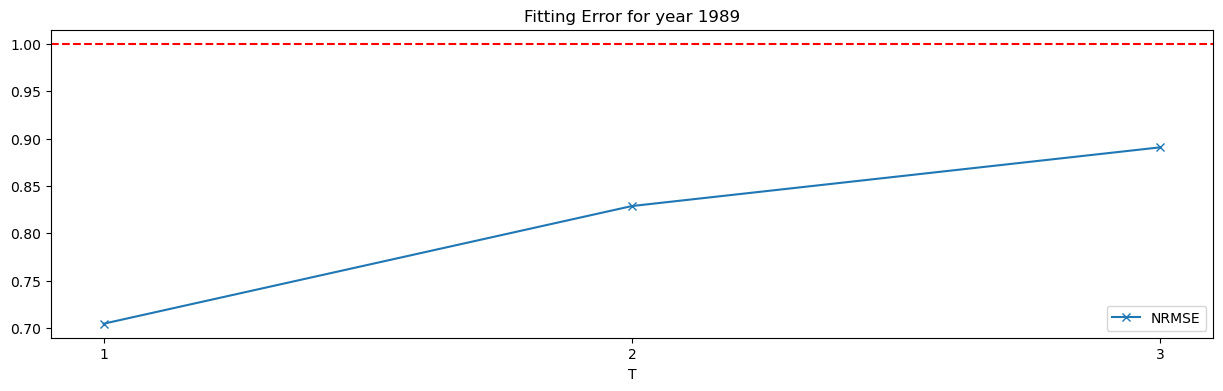

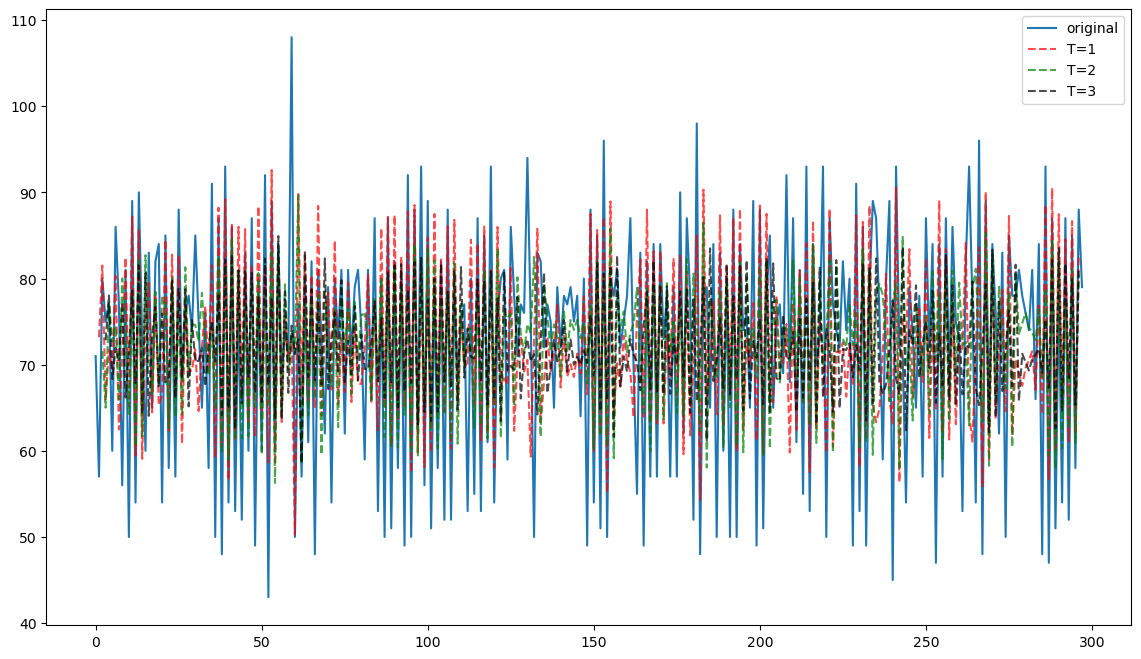

In [206]:
###FIT MODEL - Find best fit model for year 1989

autoarima_model = pm.auto_arima(d89.values,start_p=1,start_q=1,max_p=5,max_q=5,stationary=True,trace=True,)
best_p=autoarima_model.order[0]
best_q=autoarima_model.order[2]
best_aic=autoarima_model.aic()
print("Best model for year 1989 is AR order:",best_p," MA order: ",best_q," aic: ",best_aic)
summary, fittedvalues, resid, model, aic = fit_arima_model(data=d89.values, p=best_p, q=best_q, d=0)
nrmse, pred = calculate_fitting_error(d89.values, model, year=" 1989",Tmax=4, show=True)

### Year 2000

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1947.905, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1958.185, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1945.379, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1944.568, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3520.538, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1946.194, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1948.252, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3177.104, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.362 seconds
Best model for year 2000 is AR order: 0  MA order:  1  aic:  1944.567874932292


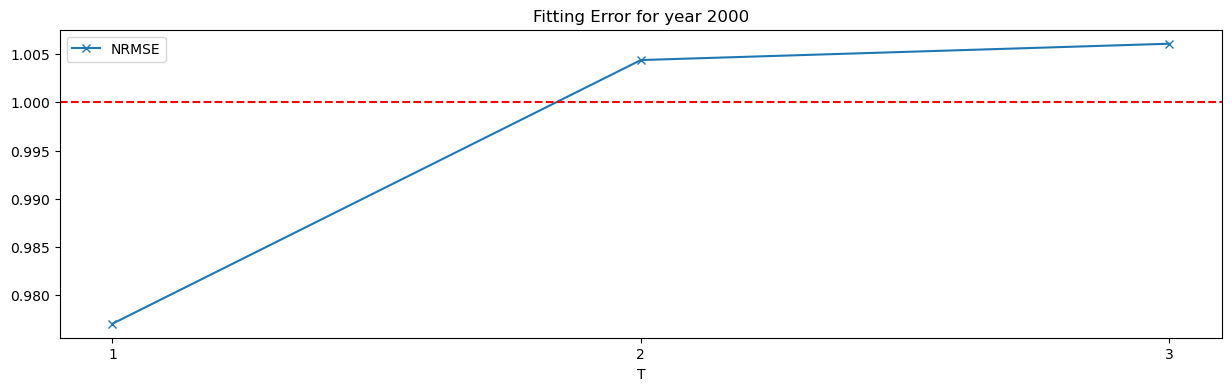

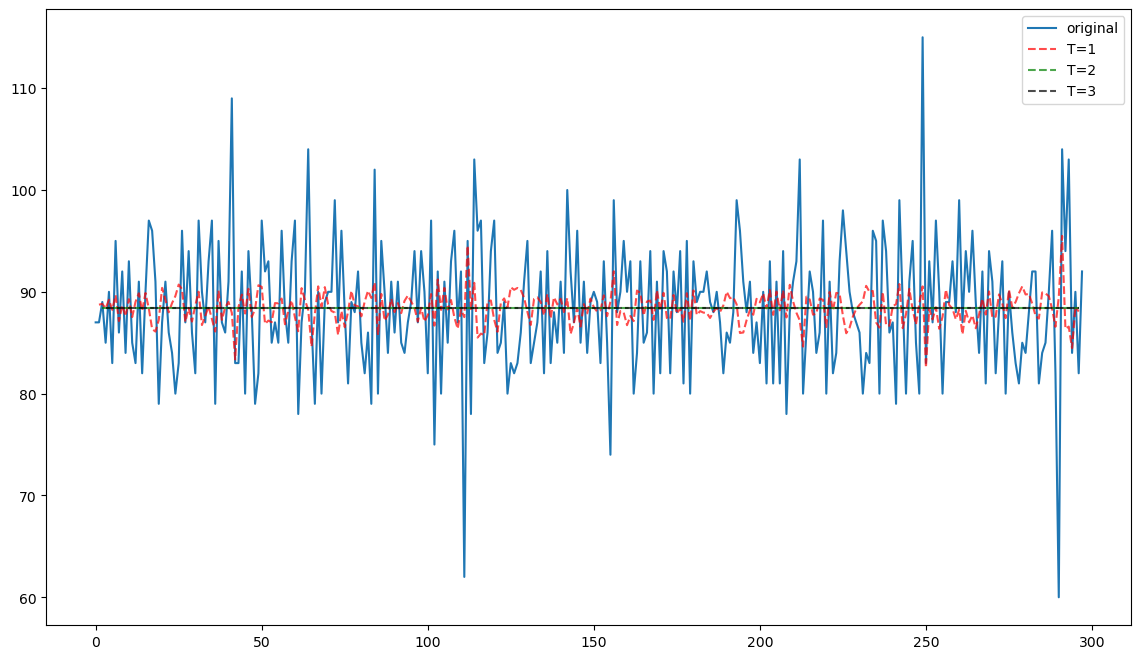

In [207]:
###FIT MODEL - Find best fit model for year 2000

autoarima_model = pm.auto_arima(d00.values,start_p=1,start_q=1,max_p=5,max_q=5,stationary=True,trace=True,)
best_p=autoarima_model.order[0]
best_q=autoarima_model.order[2]
best_aic=autoarima_model.aic()
print("Best model for year 2000 is AR order:",best_p," MA order: ",best_q," aic: ",best_aic)
summary, fittedvalues, resid, model, aic = fit_arima_model(data=d00.values, p=best_p, q=best_q, d=0)
nrmse, pred = calculate_fitting_error(d00.values, model,year=" 2000", Tmax=4, show=True)

### Year 2011

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1310.919, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1318.423, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1309.512, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1309.991, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2339.576, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1311.332, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1312.277, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.394 seconds
Best model for year 2011 is AR order: 1  MA order:  0  aic:  1309.5120701792055


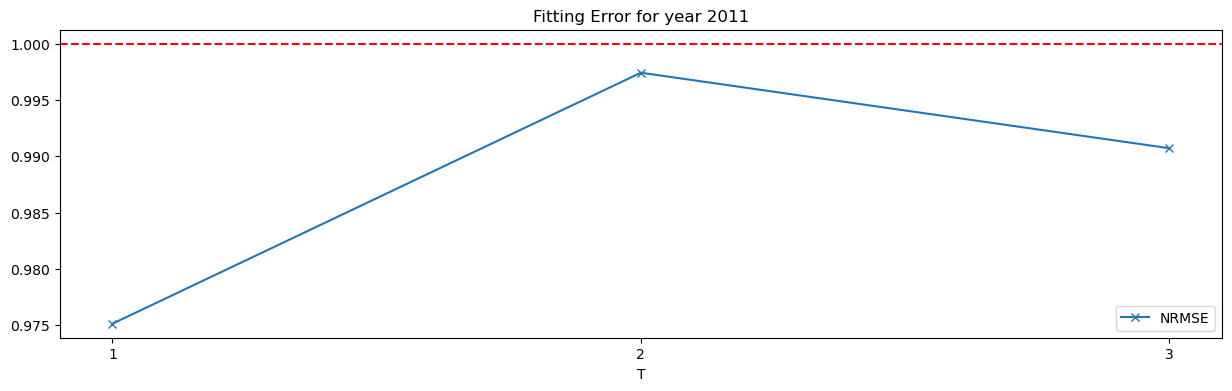

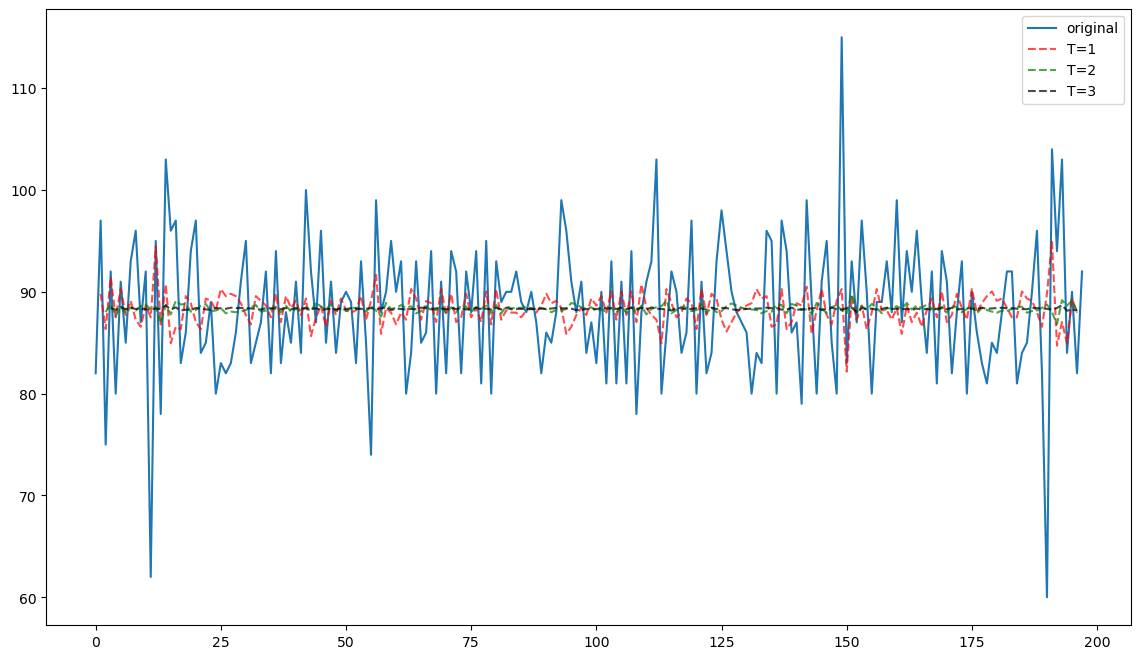

In [208]:
###FIT MODEL - Find best fit model for year 2011

autoarima_model = pm.auto_arima(d11.values,start_p=1,start_q=1,max_p=5,max_q=5,stationary=True,trace=True,)
best_p=autoarima_model.order[0]
best_q=autoarima_model.order[2]
best_aic=autoarima_model.aic()
print("Best model for year 2011 is AR order:",best_p," MA order: ",best_q," aic: ",best_aic)
summary, fittedvalues, resid, model, aic = fit_arima_model(data=d11.values, p=best_p, q=best_q, d=0)
nrmse, pred = calculate_fitting_error(d11.values, model,year=" 2011", Tmax=4, show=True)

## Part B

### Reading and choosing  data for analysis

In [210]:
d09full = pd.read_csv('./Downloads/EruptionData/eruption2009.dat',header=None)

In [215]:
#setting random number generator
rng = np.random.default_rng(12345)
#finding a random number that will be the index in the data that we will choose 500 values from eruption2009
r = rng.integers(low=0, high=d09full.shape[0]-500)
print("Random number:",r)
#chosing 500 consecutive values from eruption2009 that i will use for analysis in next steps
d09part=d09full.iloc[r:r+500]

Random number: 3697


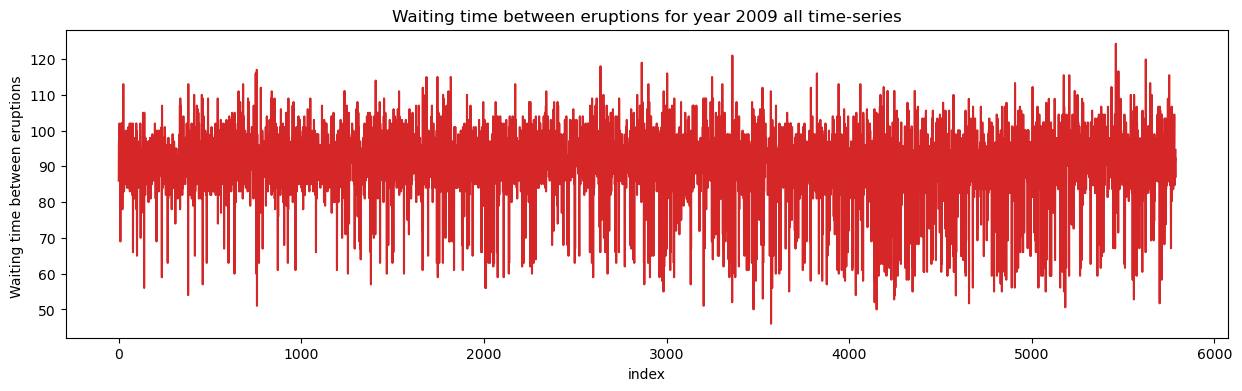

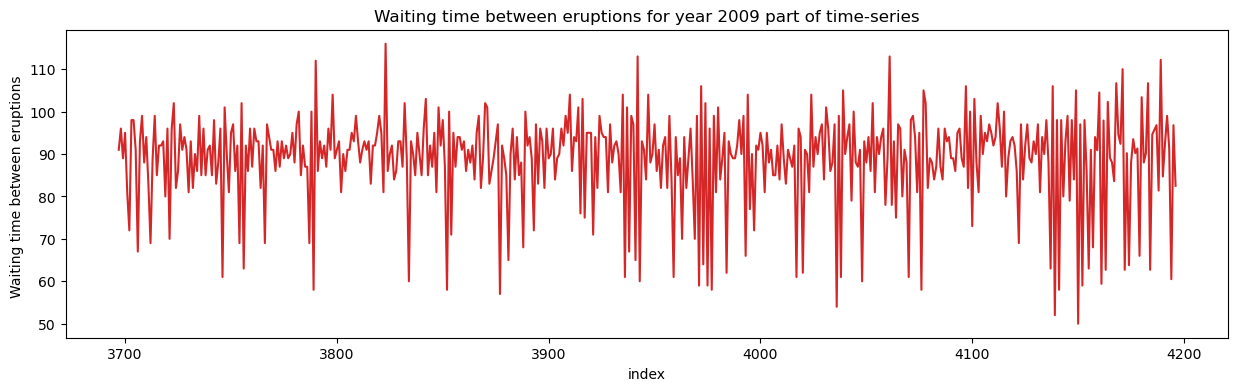

In [216]:
plot_df(d09full, x=d09full.index.values, y=d09full.values, title='Waiting time between eruptions for year 2009 all time-series')
plot_df(d09part, x=d09part.index.values, y=d09part.values, title='Waiting time between eruptions for year 2009 part of time-series')

### Check if time-series are independent

Ljung-Box test for year 2009 full data:  p = [3.15345573e-132 8.88570042e-178 8.89360662e-183 2.28452205e-189
 3.21398769e-188 3.18861947e-187 1.53140652e-186 1.43845355e-185
 2.52551441e-185 7.77686376e-185 7.22038554e-184 5.43944580e-184
 4.30968545e-183 3.24428897e-182 1.24105996e-181 2.69196547e-181
 2.05313066e-180 3.36035537e-180 1.17277790e-179 2.33541237e-179
 1.53447937e-178 2.68370536e-179 1.54965951e-178 1.78768903e-178
 4.32526907e-178 2.63208164e-177 2.34395938e-177 3.69351497e-177
 2.14171872e-176 2.29491477e-176 1.13779574e-175 5.73998892e-175
 8.92417722e-176 3.33321253e-175 4.77272212e-175 2.48322656e-174
 2.16345256e-175 7.08158877e-175 8.85980869e-176 4.05839748e-175
 8.14298387e-175 3.87873116e-174 4.68501416e-174 1.92630842e-173
 9.06990369e-173 3.76450659e-172 9.89483104e-172 2.56531711e-171
 9.62721629e-171 8.26779295e-171]
Ljung-Box test for year 2009 part of data:  p = [1.92330450e-20 7.26853726e-27 5.66418694e-27 3.25136805e-26
 1.89306559e-25 8.23260305e-25 3

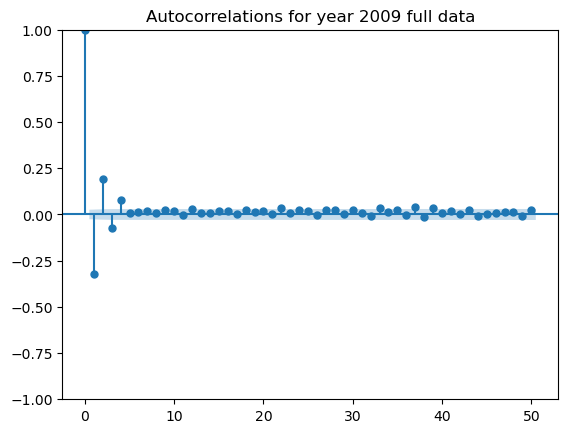

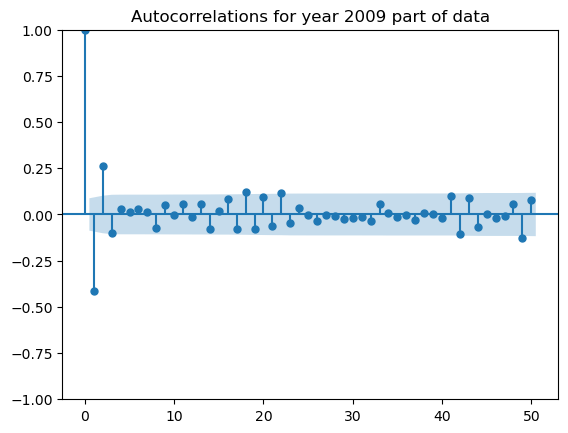

In [217]:
# Calculate the autocorrelations of the time series 50 lags for every year
lags = 50
acf_vals09full = acf(d09full.values, nlags=lags)
acf_vals09part = acf(d09part.values, nlags=lags)

#plot autocorrelations for each time-series for each lag and limits for alpha=0.05
plot_acf(d09full.values, lags=lags,alpha=0.05,title="Autocorrelations for year 2009 full data")
plot_acf(d09part.values, lags=lags,alpha=0.05,title="Autocorrelations for year 2009 part of data")
# Perform the Ljung-Box test for each one
lb_test09full = acorr_ljungbox(d09full.values, lags=lags)
lb_test09part= acorr_ljungbox(d09part.values, lags=lags)
# Print the  p-values 
print(f"Ljung-Box test for year 2009 full data:  p = {lb_test09full.iloc[:,1].values}")
print(f"Ljung-Box test for year 2009 part of data:  p = {lb_test09part.iloc[:,1].values}")

### Estimation of lag from mutual information

Estimated delay from mutual information is tau=  3


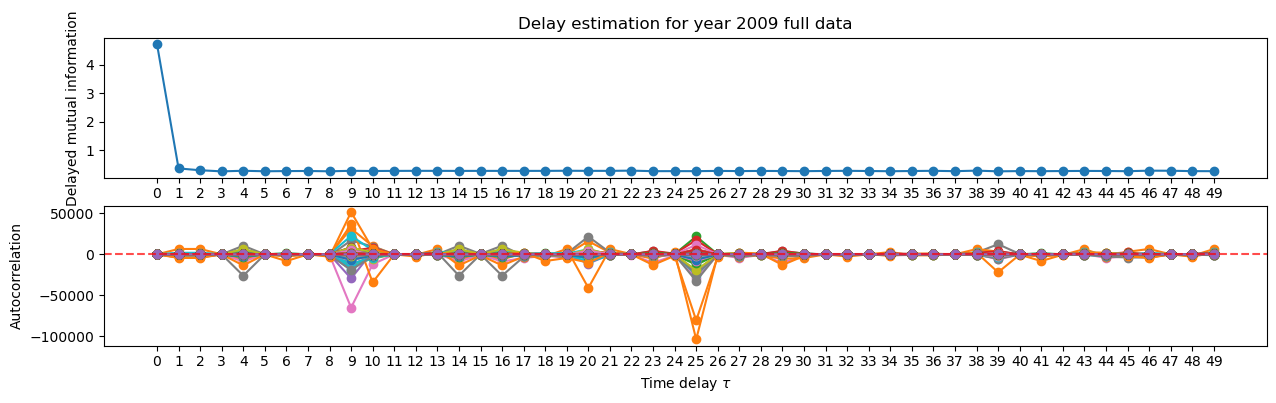

In [250]:
####Compute autocorrelation and delayed mutual information for multiple lags for year 2009 full data
maxtau = 50
lags = np.arange(maxtau)
acf= delay.acorr(d09full.values, maxtau=maxtau)
mi = delay.dmi(np.squeeze(d09full.values), maxtau=maxtau)

###Choice of tau
###Plot delayed mutual information and autocorrrelation
plt.figure(1, figsize=(15, 4))
plt.subplot(211)
plt.title(r'Delay estimation for year 2009 full data')
plt.ylabel(r'Delayed mutual information')
plt.plot(lags, mi, marker='o')
plt.xticks(lags)
plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lags, acf, '-o')
plt.axhline(1.0 / np.e, linestyle='--', alpha=0.7, color='red' )
plt.xticks(lags)

diffmi = np.diff(mi)
tau09full=np.where(diffmi > 0)[0][0]
print("Estimated delay from mutual information is tau= ",tau09full)

Estimated delay from mutual information is tau=  3


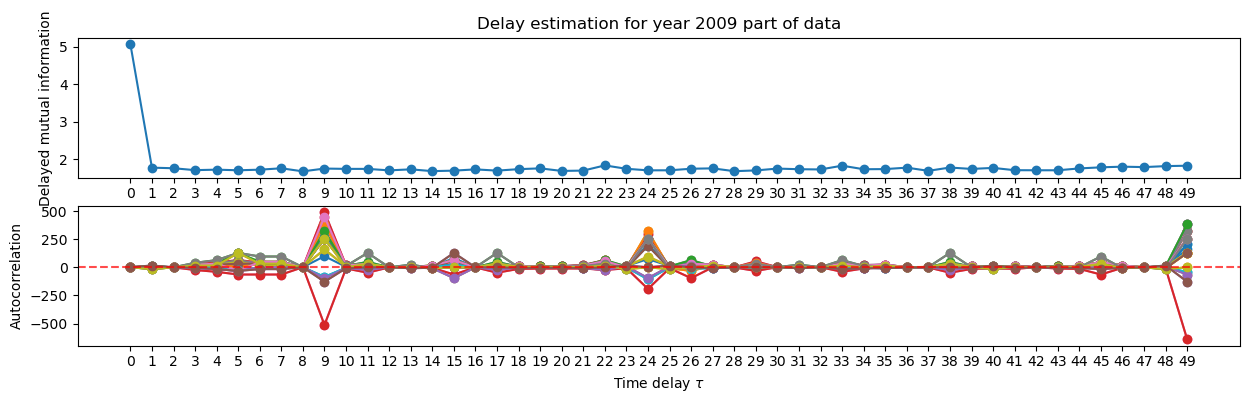

In [251]:
####Compute autocorrelation and delayed mutual information for multiple lags for year 2009 part of data data
maxtau = 50
lags = np.arange(maxtau)
acf= delay.acorr(d09part.values, maxtau=maxtau)
mi = delay.dmi(np.squeeze(d09part.values), maxtau=maxtau)

###Choice of tau
###Plot delayed mutual information and autocorrrelation
plt.figure(1, figsize=(15, 4))
plt.subplot(211)
plt.title(r'Delay estimation for year 2009 part of data')
plt.ylabel(r'Delayed mutual information')
plt.plot(lags, mi, marker='o')
plt.xticks(lags)
plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lags, acf, '-o')
plt.axhline(1.0 / np.e, linestyle='--', alpha=0.7, color='red' )
plt.xticks(lags)

diffmi = np.diff(mi)
tau09part=np.where(diffmi > 0)[0][0]
print("Estimated delay from mutual information is tau= ",tau09part)

### Finding embedding dimension m with False Nearest Neighbors 

Estimated embedding dimension m from FNN with tau=3 is m=  4


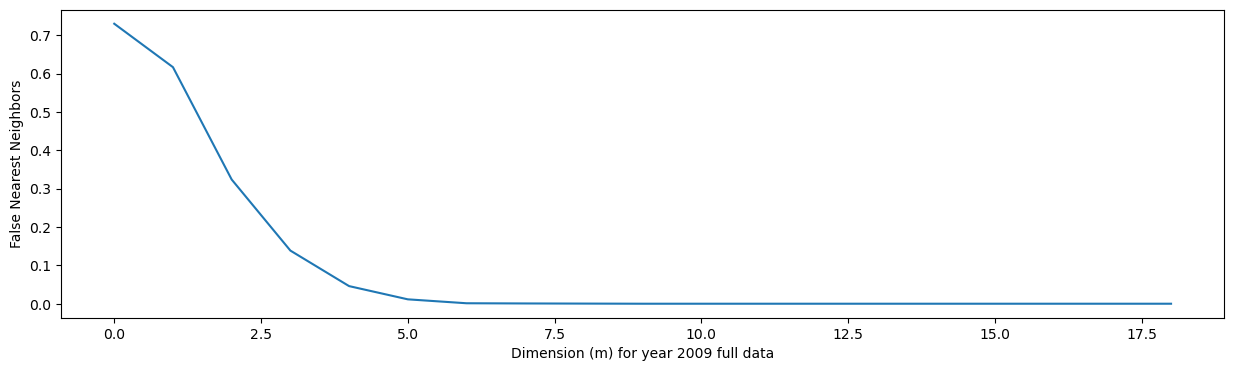

In [263]:
max_dim=20
dim = np.arange(1, max_dim)
f1, f2, f3 = dimension.fnn(np.squeeze(d09full.values), tau=tau09full, dim=dim,maxnum=1000)
plt.figure(figsize=(15,4))
plt.xlabel('Dimension (m) for year 2009 full data')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)
m09full=np.where(f1 < 0.2)[0][0] + 1
print("Estimated embedding dimension m from FNN with tau=3 is m= ",m09full)

Estimated embedding dimension m from FNN with tau=3 is m=  3


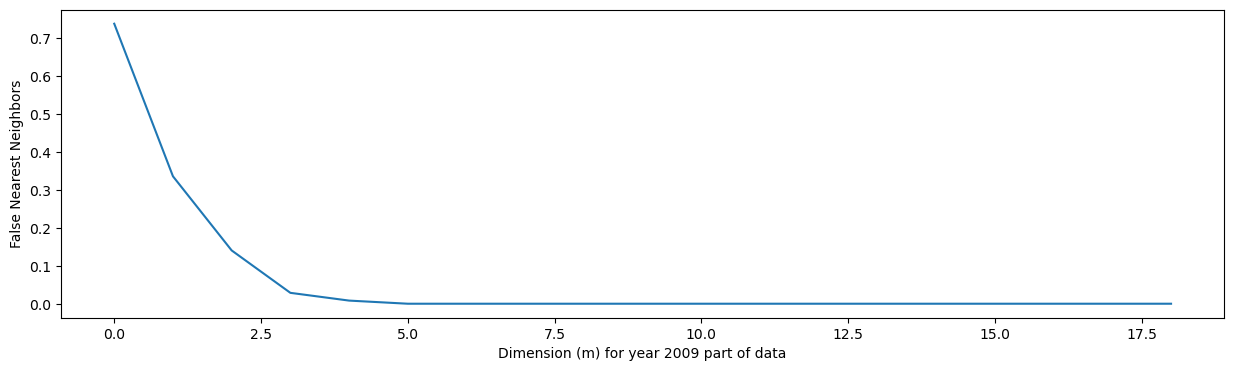

In [265]:
max_dim=20
dim = np.arange(1, max_dim)
f1, f2, f3 = dimension.fnn(np.squeeze(d09part.values), tau=tau09part, dim=dim,maxnum=100)
plt.figure(figsize=(15,4))
plt.xlabel('Dimension (m) for year 2009 part of data')
plt.ylabel('False Nearest Neighbors')
plt.plot(f1)
m09part=np.where(f1 < 0.2)[0][0] + 1
print("Estimated embedding dimension m from FNN with tau=3 is m= ",m09part)